In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

input_data_ordered_raw =  pd.read_csv('rnap_scanned_over_ecoli_genome200k.csv')
sequences = input_data_ordered_raw['seq'].tolist()

In [2]:
input_data_ordered_raw.head()

,Unnamed: 0,val,seq,left,right,ori,contig
0,0,23.9083,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG,3695629,3695669,+,MG1655.fa
1,1,23.5831,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG,1109059,1109099,+,MG1655.fa
2,2,23.4205,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG,822216,822256,-,MG1655.fa
3,3,23.4098,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC,772478,772518,+,MG1655.fa
4,4,23.3640,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT,2748531,2748571,+,MG1655.fa


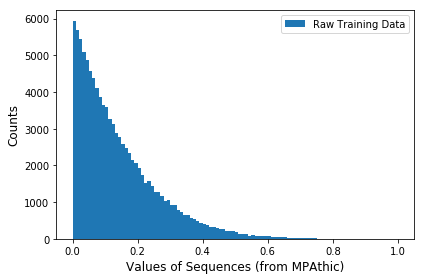

In [3]:
unbalanced_pos_labels = np.array(input_data_ordered_raw['val'][0:100000])
unbalanced_pos_labels = (unbalanced_pos_labels-min(unbalanced_pos_labels))/(max(unbalanced_pos_labels)-min(unbalanced_pos_labels))

plt.hist(unbalanced_pos_labels,bins=100,label='Raw Training Data')
plt.legend()
plt.ylabel('Counts',fontsize=12)
plt.xlabel('Values of Sequences (from MPAthic)',fontsize=12)
#plt.title('Convolutional Neural Network Performance')
plt.tight_layout()
#
#plt.savefig('Write_up/raw_data_histogram.png')
plt.show()



## Randomly sample vals and seqs to prevent data imbalance

In [4]:
input_data_ordered_raw[['val','seq']].head()

,val,seq
0,23.9083,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG
1,23.5831,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG
2,23.4205,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG
3,23.4098,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC
4,23.3640,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT


In [5]:
# normally sample high value seqs more
# https://stackoverflow.com/questions/33160367/numpy-how-to-generate-a-normally-distributed-set-of-integers
bi = np.random.binomial(n=10000, p=0.5, size=1000)
beta = np.random.beta(a=19,b=1,size=50000)
myList = list(100000*beta)
myList = [round(x) for x in myList]

In [6]:
#plt.hist(myList, bins=100)
#plt.show()
#np.random.seed(1)    # good seeds: 10,5,1
# for larger data, seed 2,5 is okay.
np.random.seed(6)    

In [7]:
num_sample = 90000   # number of training samplesq
test_size = 5000    # number of test samples


#num_sample = 40000   # number of training samplesq
#test_size = 1000    # number of test samples

binomial_probability_parameter = 0.5

index_random_sample_training_data = np.random.randint(num_sample,size=(num_sample))
###index_random_sample_training_data = np.random.binomial(n=200000, p=binomial_probability_parameter, size=num_sample)

#beta = np.random.beta(a=20,b=1,size=num_sample)
#index_random_sample_training_data = list(100000*beta)
#index_random_sample_training_data = [round(x) for x in index_random_sample_training_data]

#index_random_sample_training_data = set(index_random_sample_training_data)
#index_random_sample_training_data = list(index_random_sample_training_data)

input_data_raw = input_data_ordered_raw[['val','seq']].loc[index_random_sample_training_data]
print(input_data_raw.head())

index_random_sample_test_data = np.random.randint(num_sample,size=(test_size))
###index_random_sample_test_data = np.random.binomial(n=200000, p=binomial_probability_parameter, size=test_size)

#beta_test = np.random.beta(a=20,b=1,size=test_size)
#index_random_sample_test_data = list(100000*beta_test)
#index_random_sample_test_data = [round(x) for x in index_random_sample_test_data]


#index_random_sample_test_data = set(index_random_sample_test_data)
#index_random_sample_test_data = list(index_random_sample_test_data)

input_data_raw_test = input_data_ordered_raw[['val','seq']].loc[index_random_sample_test_data]

print(input_data_raw_test.head())

           val                                        seq
31626  20.4539  CTCATCCACGCTTAAAAAACGCGGGTAAATCATGATCGCGT
41187  20.3047  TCACAGCAAATTCGCCTGGTCACGCTCTCCGGTGGCGTCGG
4714   21.3827  GAACTGCCCGCCGCGAATGGTTCCCTGCAGGCGGTTCACTT
64877  20.0282  TTCGAACTCACCGCCCAGCAGTTCTTCCCAGTTTGGCCCCC
41295  20.3031  GGGATAGCTGCGACATCATTTTGGTTACTGGCGACGCGTAT
           val                                        seq
87941  19.8315  TCTATCGCCGGTTGCGATGCTTTGCTGAACGCAGCCTGAGC
2829   21.5992  CTGCTACATTGAACGTATTCGACGTAACGGGATTCTGGCAA
51415  20.1728  GGCTTCCCGATTAACGAATATAACTCGCTGCGTGCAGGTCT
67730  20.0015  TAGGTTCATGCCAGGCCGTTTGCGACCAGCTGGGGTCCGAA
65639  20.0203  GCAAGGAACGCTGCATACTCTGCAACTCGGCTATCCGTGCT


In [8]:
#from random import shuffle
#shuffle(index_random_sample_training_data)
#shuffle(index_random_sample_test_data)

In [9]:
#num_sample = len(set(index_random_sample_training_data))
#test_size = len(set(index_random_sample_test_data))

## Ensure no test data got into training dataset

In [10]:
input_data_raw = input_data_raw[~input_data_raw.seq.isin(input_data_raw_test.seq)]
#input_data_raw = input_data_raw.drop_duplicates()

In [11]:
#test_size = len(input_data_raw_test.drop_duplicates())
test_size = len(input_data_raw_test)
print(test_size)

5000


In [12]:
#num_sample = len(input_data_raw.drop_duplicates())
num_sample = len(input_data_raw)

## Make Labels

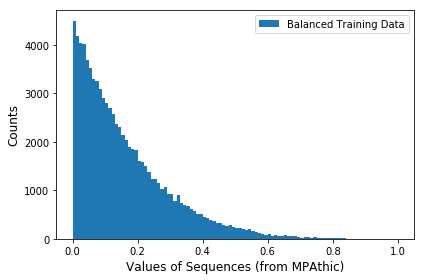

In [13]:
# positive and negative labels
# normalize the following between 0 and 1
pos_labels = np.array(input_data_raw['val'][0:num_sample])
pos_labels = (pos_labels-min(pos_labels))/(max(pos_labels)-min(pos_labels))

# test positive and negative labels
test_pos_labels = np.array(input_data_raw_test['val'][0:test_size])
test_pos_labels = (test_pos_labels-min(test_pos_labels))/(max(test_pos_labels)-min(test_pos_labels))

#plt.hist(pos_labels,bins=50,label='Balanced Training Data')
plt.hist(pos_labels,bins=100,label='Balanced Training Data')
plt.legend()

plt.ylabel('Counts',fontsize=12)
plt.xlabel('Values of Sequences (from MPAthic)',fontsize=12)
plt.tight_layout()
#plt.savefig('Write_up/balanced_training_histogram.png')
plt.show()
# assigned random values to negative examples

### Visualize test data

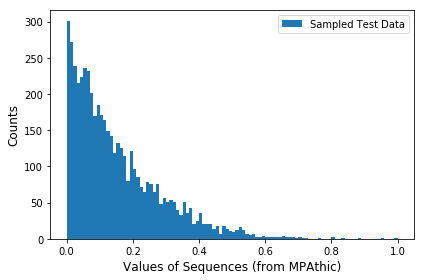

In [14]:
#plt.hist(pos_labels,bins=50,label='Balanced Training Data')
plt.hist(test_pos_labels,bins=100,label='Sampled Test Data')
plt.legend()

plt.ylabel('Counts',fontsize=12)
plt.xlabel('Values of Sequences (from MPAthic)',fontsize=12)
plt.tight_layout()
#plt.savefig('Write_up/balanced_training_histogram.png')
plt.show()

In [15]:
sequences = np.array(sequences)

pos = []
#pos = list(sequences[index_random_sample_training_data])
pos = list(input_data_raw['seq'])

test_pos = []
#test_pos = list(sequences[index_random_sample_test_data])
test_pos = list(input_data_raw_test['seq'])

pos = np.array(pos)
test_pos = np.array(test_pos)

seq_length = len(pos[0])

In [16]:
 input_data_raw_test.head()

,val,seq
87941,19.8315,TCTATCGCCGGTTGCGATGCTTTGCTGAACGCAGCCTGAGC
2829,21.5992,CTGCTACATTGAACGTATTCGACGTAACGGGATTCTGGCAA
51415,20.1728,GGCTTCCCGATTAACGAATATAACTCGCTGCGTGCAGGTCT
67730,20.0015,TAGGTTCATGCCAGGCCGTTTGCGACCAGCTGGGGTCCGAA
65639,20.0203,GCAAGGAACGCTGCATACTCTGCAACTCGGCTATCCGTGCT


In [17]:
test_pos_labels[0]

0.0037178670065857594

## One-hot encoding

In [18]:
temp_pos = []
temp_pos_test = []
for reshape_index in range(len(pos)):
    temp_pos.append(list(pos[reshape_index]))

for reshape_test_index in range(len(test_pos)):
    temp_pos_test.append(list(test_pos[reshape_test_index]))
    
pos = temp_pos
test_pos = temp_pos_test

In [19]:
pos = np.array(pos)
test_pos = np.array(test_pos)

In [20]:
pos_tensor = np.zeros(list(pos.shape) + [4])
test_pos_tensor = np.zeros(list(test_pos.shape) + [4])

base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#naive one-hot encoding
for row in range(num_sample):
    for col in range(seq_length):
        pos_tensor[row,col,base_dict[pos[row,col]]] = 1
        if(row<test_size):
            test_pos_tensor[row,col,base_dict[test_pos[row,col]]] = 1

#print('Positive sample matrix shape: {}'.format(pos.shape))
# this should be a 3D tensor with shape: (samples, steps, input_dim)
#print('Positive sample tensor shape: {}'.format(pos_tensor.shape))

X = pos_tensor
y = pos_labels

X_test = test_pos_tensor
y_test = test_pos_labels

print('Training set shape: {}'.format(X.shape))
print('Training set label shape: {}'.format(y.shape))

print('Test set shape: {}'.format(X_test.shape))
print('Test set label shape: {}'.format(y_test.shape))
#print('\nOne-hot encoding looks like:\n {}'.format(X[0,0:10,:]))

Training set shape: (84612, 41, 4)
Training set label shape: (84612,)
Test set shape: (5000, 41, 4)
Test set label shape: (5000,)


# Define error metrics

In [21]:
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

## Define Models

In [22]:
#here comes the deep learning part
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D,GlobalMaxPool1D
from keras.optimizers import SGD, Adam
from keras.initializers import TruncatedNormal,glorot_normal

#sanity check for dimensions
#print('Shape of the output of first layer: {}'.format(model.predict_on_batch(pos_tensor[0:1,:,:]).shape))

Using TensorFlow backend.


In [23]:

model = Sequential()
# padding same works
#model.add(Conv1D(filters = 41, kernel_size=41, padding='same', input_shape=(seq_length, 4), activation='relu'))
#model.add(Conv1D(41, 41, input_shape=(seq_length, 4),padding='same', activation='relu',kernel_initializer=glorot_normal(0)))
model.add(Conv1D(10, 41, input_shape=(seq_length, 4),padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(4, 10, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
#model.add(Conv1D(10, 4, input_shape=(seq_length, 4),padding='same', activation='relu'))
#model.add(Conv1D(10, 10, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(Conv1D(30, 15, padding='same', input_shape=(seq_length, 4), activation='relu'))
#model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
#model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
#model.add(Dense(1, activation='relu'))

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

#model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error',r_square])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=[rmse,r_square])
#model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0001), metrics=[rmse,r_square])
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0001), metrics=['mean_squared_error'])

#history = model.fit(X, y, validation_split=0.2, epochs=50)  # starts training
history = model.fit(X, y, validation_split=0.2, epochs=20)  # starts training



Train on 67689 samples, validate on 16923 samples
Epoch 1/20
67689/67689 [==============================] - 6s 86us/step - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0192 - val_mean_squared_error: 0.0192
Epoch 2/20
67689/67689 [==============================] - 6s 84us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 3/20
67689/67689 [==============================] - 6s 92us/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 4/20
67689/67689 [==============================] - 6s 91us/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 5/20
67689/67689 [==============================] - 6s 89us/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 6/20
67689/67689 [==============================] - 6s 90us/step - loss: 0.0113 - mean_squared_error: 0.0113 

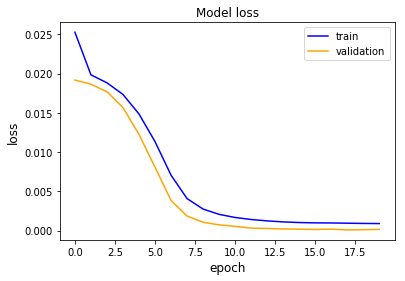

In [24]:
plt.figure()
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

In [25]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

In [26]:
'''
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(history.history['val_rmse'],color='orange')
plt.plot(history.history['rmse'],color='b')
plt.title('Model RMSE',fontsize=12)
plt.ylabel('RMSE',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
plt.savefig('Write_up/RMSE_loss.png')
plt.legend(['rmse', 'val_rmse'], loc='upper right')
#plt.savefig('Write_up/rmse.png')
plt.show()
'''

'\nplt.rcParams["figure.figsize"] = (5,5)\nplt.plot(history.history[\'val_rmse\'],color=\'orange\')\nplt.plot(history.history[\'rmse\'],color=\'b\')\nplt.title(\'Model RMSE\',fontsize=12)\nplt.ylabel(\'RMSE\',fontsize=12)\nplt.xlabel(\'epoch\',fontsize=12)\nplt.legend([\'train\', \'validation\'])\nplt.savefig(\'Write_up/RMSE_loss.png\')\nplt.legend([\'rmse\', \'val_rmse\'], loc=\'upper right\')\n#plt.savefig(\'Write_up/rmse.png\')\nplt.show()\n'

In [27]:
'''
#plt.rcParams["figure.figsize"] = (5,5)
plt.plot(history.history['val_r_square'],color='b')
plt.plot(history.history['r_square'],color='orange')
plt.title('model R^2',fontsize=12)
plt.ylabel('R^2',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['r_sq', 'val_r_sq'], loc='lower right')
plt.tight_layout()
#plt.savefig('Write_up/Rsquared.png')
plt.show()
'''

'\n#plt.rcParams["figure.figsize"] = (5,5)\nplt.plot(history.history[\'val_r_square\'],color=\'b\')\nplt.plot(history.history[\'r_square\'],color=\'orange\')\nplt.title(\'model R^2\',fontsize=12)\nplt.ylabel(\'R^2\',fontsize=12)\nplt.xlabel(\'epoch\',fontsize=12)\nplt.legend([\'r_sq\', \'val_r_sq\'], loc=\'lower right\')\nplt.tight_layout()\n#plt.savefig(\'Write_up/Rsquared.png\')\nplt.show()\n'

In [28]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))

num2seq = ['A','C','G','T']

#''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])
#test_pred = ''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])

Convolution parameter shape: (41, 4, 10)


## Make predictions

In [29]:
model_prediction = model.predict(X_test)

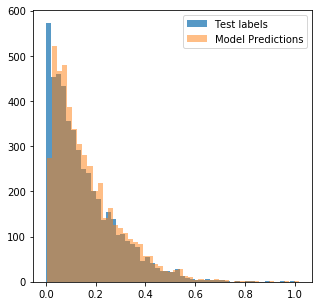

In [30]:
plt.hist(test_pos_labels,bins=50,alpha=0.75,label='Test labels')
plt.hist(model_prediction,bins=50,alpha=0.5,label='Model Predictions')
plt.legend()
plt.show()

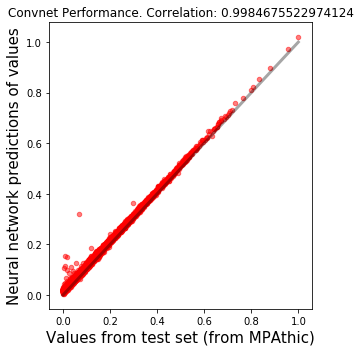

In [31]:
pos_model_prediction = model.predict(test_pos_tensor)
#from pylab import rcParams
#rcParams['xtick.labelsize'] = 15 
#rcParams['ytick.labelsize'] = 15 
#rcParams['figure.figsize'] = 6, 6

plt.scatter(y_test,pos_model_prediction,s=20,alpha=0.5,color='red')
plt.plot([0,1],alpha=0.35,linewidth=3,color='black')
plt.ylabel('Neural network predictions of values',fontsize=15)
plt.xlabel('Values from test set (from MPAthic)',fontsize=15)
plt.title('Convnet Performance. Correlation: '+str(np.corrcoef(y_test,pos_model_prediction.flatten())[1,0]))
plt.tight_layout()
#plt.rcParams['axes.facecolor']='white'
#plt.rcParams['savefig.facecolor']='white'
#plt.savefig('prediction_vs_observed.png',facecolor=fig.get_facecolor(), transparent=True)
#plt.savefig('prediction_vs_observed.png')
plt.show()


## Compute Saliency and Plot it

In [32]:
import tensorflow.keras.backend as K
import tensorflow as tf

K.set_session(tf.Session(graph=model.output.graph)) 
init = tf.global_variables_initializer() 
K.get_session().run(init)

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][0], model.input)
  
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  x_value = np.expand_dims(x, axis=0)

  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal


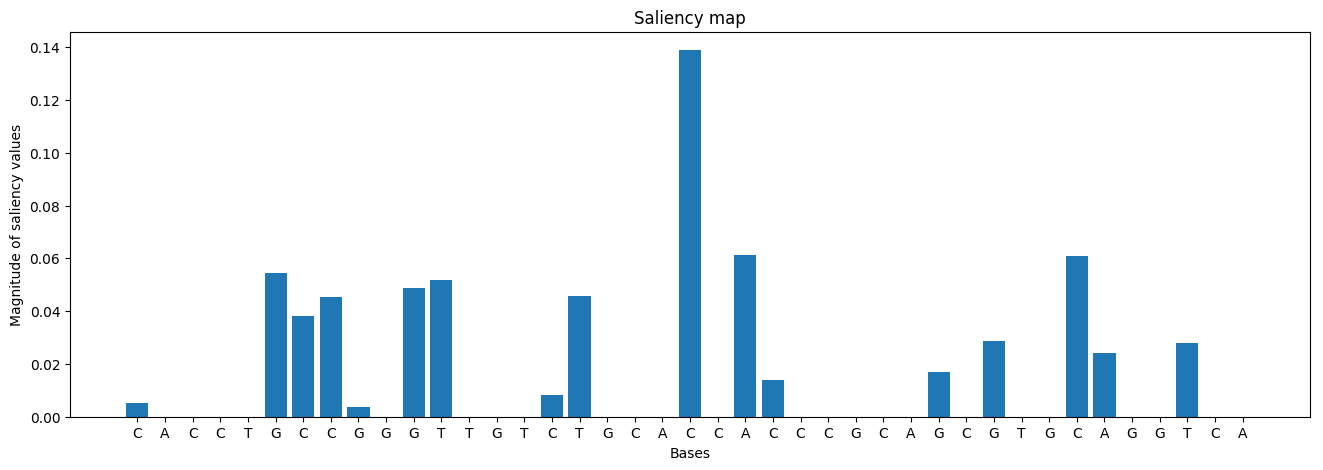

In [77]:
sequence_index = model_prediction.argmax()
sequence_index = 3000
sal = compute_salient_bases(model, X_test[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
#[barlist[i].set_color('C1') for i in range(5,17)]
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map');
plt.show()

## Compare prediction of individual sequence against model

In [34]:
predict_single_sequence = 230
print('prediction: ')
print(model.predict(X_test[predict_single_sequence:predict_single_sequence+1]))

label_single_sequence = predict_single_sequence
print('label: ')
print(test_pos_labels[label_single_sequence:label_single_sequence+1])


prediction: 
[[0.18899988]]
label: 
[0.19412577]


## Visualize convolution filters

shape of conv1d layer
(41, 4, 10)


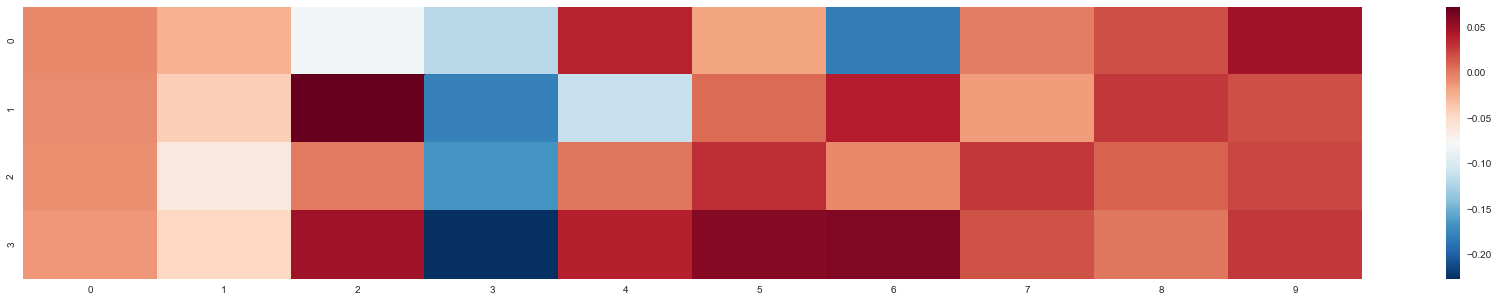

In [35]:
#model.get_weights()[0][:,0,0]
# values of first filter
#model.get_weights()[0][0].T

print('shape of conv1d layer')
print(np.shape(model.get_weights()[0]))
plt.rcParams["figure.figsize"] = (30,5)
import seaborn as sns
sns.set()
sns.heatmap(model.get_weights()[0][10],cmap='RdBu_r')

plt.show()

In [36]:
np.shape(model.get_weights()[0])

(41, 4, 10)

In [37]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))

#convlayer2 = model.layers[2]
#weights2 = convlayer2.get_weights()[0].squeeze()
#print('Convolution parameter shape: {}'.format(weights2.shape))

num2seq = ['A','C','G','T']

#''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])
#test_pred = ''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])

Convolution parameter shape: (41, 4, 10)


In [38]:
#argmax_conv_filter_list = []
#for filter_index in range(41):
#    argmax_conv_filter_list.append(''.join([num2seq[np.argmax(model.get_weights()[0][filter_index][:,x])] for x in range(41)]))

In [39]:
#for fa_index in range(len(argmax_conv_filter_list)):
#    print('>')
#    print(argmax_conv_filter_list[fa_index])

In [40]:
import sys
sys.path.insert(0,'/Users/tareen/Desktop/Desktop_Tests/logomaker3')
import logomaker

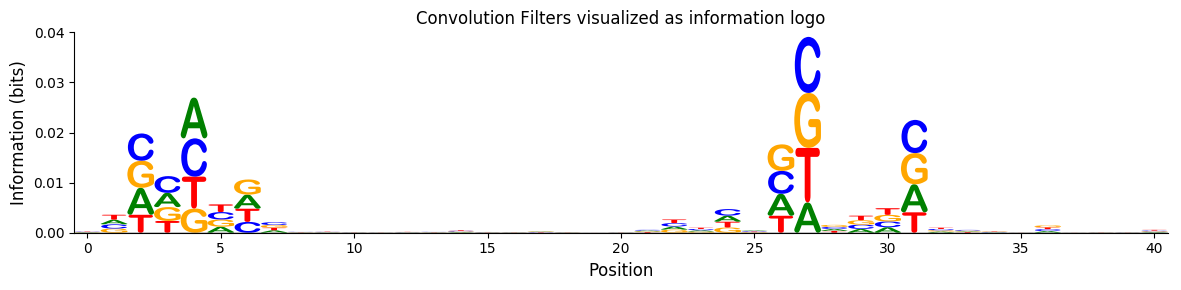

In [72]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
learned_filter = pd.DataFrame(weights[:,:,1],columns = ['A','C','G','T'])

import warnings
warnings.filterwarnings("ignore")

baseline_param_dict = {
                          'baseline_width':1.0,
                      }

logo = logomaker.make_logo(
                            dataframe=learned_filter,
                            matrix_type='information',
                            remove_flattened_characters=False,
                            ytick_format='%0.1f',
                            draw_now=True,
                            figsize=[12,3],
                            baseline_param_dict = baseline_param_dict,
                            ylim=[0,0.04]
                    )
print(logo)
plt.xlabel('Position',fontsize=12)
plt.title('Convolution Filters visualized as information logo',fontsize=12)
plt.ylabel('Information (bits)',fontsize=12)
plt.tight_layout()
plt.savefig('convolution_visualization2.png')
plt.show()


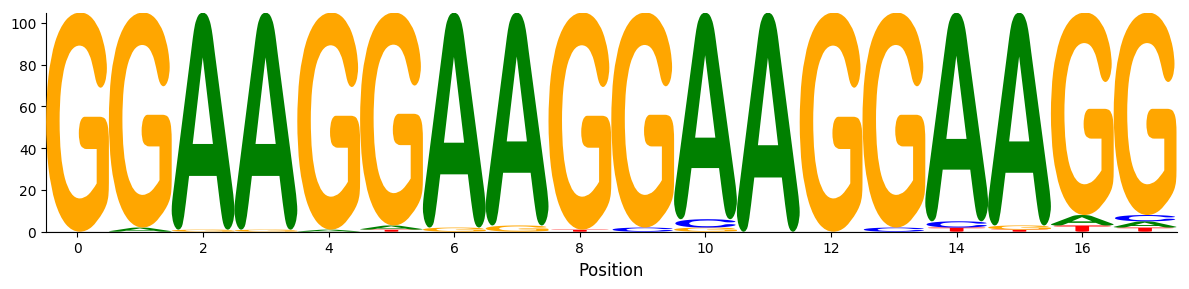

In [91]:
motif = np.array([[   0,   2, 104, 104,   1,   2, 103, 102,   0,   0,  99, 105,   0,   0, 100, 102,   5,   3],
                  [   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   4,   0,   0,   2,   3,   0,   0,   3],
                  [ 105, 103,   1,   1, 104, 102,   2,   3, 104, 103,   2,   0, 105, 103,   0,   2,  97,  97],
                  [   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   2,   1,   3,   2]])

motif_df = pd.DataFrame(motif)
motif_df = motif_df.T
motif_df.columns = ['A','C','G','T']
motif_df

logo_motif = logomaker.make_logo(
                            dataframe=motif_df,
                            #matrix_type='information',
                            remove_flattened_characters=False,
                            ytick_format='%0.1f',
                            draw_now=True,
                            figsize=[12,3],                        
                            #ylim=[0,0.04]
                    )
print(logo)
plt.xlabel('Position',fontsize=12)
plt.tight_layout()
plt.show()

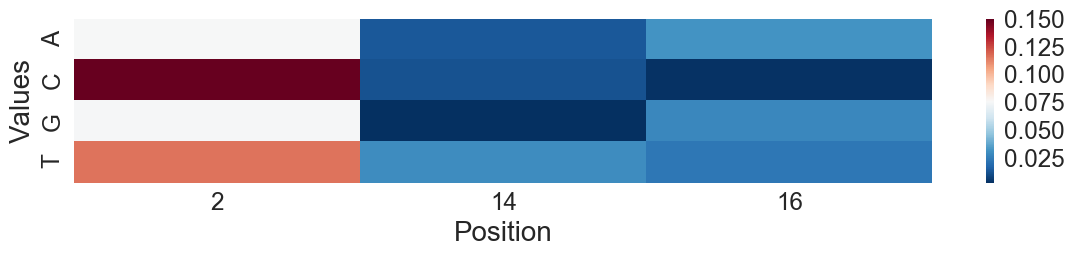

In [66]:

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.figsize"] = (12,3)
sns.set(font_scale = 1.75)
sns.heatmap(logo.df[(logo.df > 0).all(1)].T,cmap='RdBu_r')
plt.xlabel('Position',fontsize=20)
plt.ylabel('Values',fontsize=20)
plt.tight_layout()
plt.savefig('convolution_filter_hm.png')
plt.show()

In [43]:
from keras.models import load_model

#model.save('train_90k_test_5k_10_filters_1Convlayer.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('train_50k_test_2k_10_filters_1Convlayer.h5')

In [44]:
#np.shape(weights2[:,0,:])
#np.shape(weights[:,:,0])

In [45]:
'''
learned_filter2 = pd.DataFrame(weights2[:,9,:],columns = ['A','C','G','T'])

import warnings
warnings.filterwarnings("ignore")

logo = logomaker.make_logo(
                            dataframe=learned_filter2,
                            matrix_type='information',
                            remove_flattened_characters=False,
                            ytick_format='%0.1f',
                            draw_now=True,
                            figsize=[7,3],
                            ylim=[0,0.04]
                    )
print(logo)
plt.show()
'''

'\nlearned_filter2 = pd.DataFrame(weights2[:,9,:],columns = [\'A\',\'C\',\'G\',\'T\'])\n\nimport warnings\nwarnings.filterwarnings("ignore")\n\nlogo = logomaker.make_logo(\n                            dataframe=learned_filter2,\n                            matrix_type=\'information\',\n                            remove_flattened_characters=False,\n                            ytick_format=\'%0.1f\',\n                            draw_now=True,\n                            figsize=[7,3],\n                            ylim=[0,0.04]\n                    )\nprint(logo)\nplt.show()\n'

In [46]:

fig, axs = plt.subplots(5,2,figsize=[12,10])
learned_filter = pd.DataFrame(weights[:,:,0],columns = ['A','C','G','T'])

import warnings
warnings.filterwarnings("ignore")


filter_index = 0
for i in range(5):
    for j in range(2):
        learned_filter = pd.DataFrame(weights[:,:,filter_index],columns = ['A','C','G','T'])

        
        logo = logomaker.make_logo(
                                    dataframe=learned_filter,
                                    matrix_type='information',
                                    remove_flattened_characters=False,
                                    #ytick_format='%0.1f',
                                    ylim=[0,0.05],
                                    draw_now=False,
                                )
        axs[i,j].set_title(filter_index)
        filter_index+=1
        logo.draw(axs[i,j])


In [47]:
#plt.show()

In [48]:
import os
os.getcwd()

'/Users/tareen/Desktop/Desktop_Tests/MPathic3/mpathic/data/rnap_convnet'

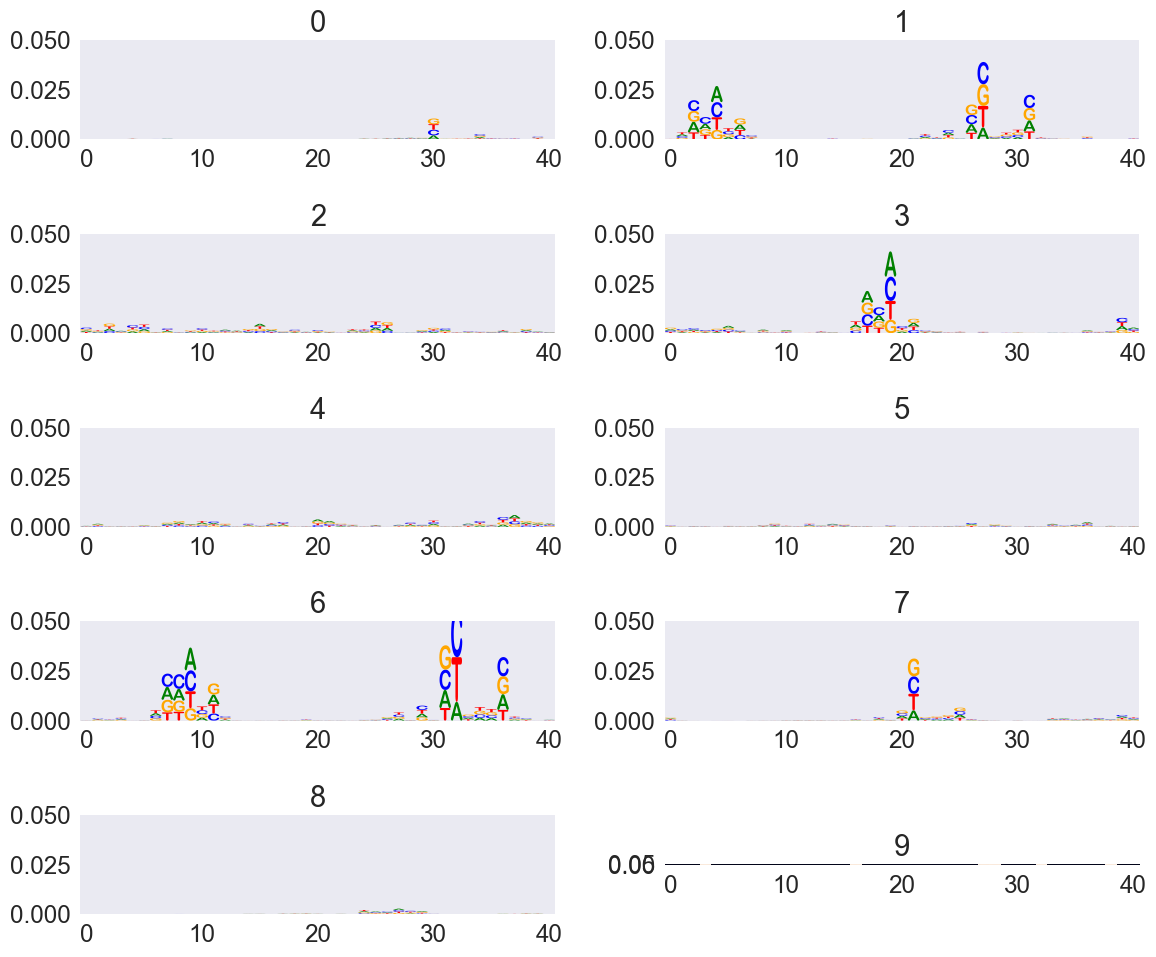

In [49]:
plt.imshow(test_pos_tensor[0].T)
plt.show()